In [217]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

In [218]:
stock_name = 'AMZN'

In [219]:
all_news = pd.read_csv('News_headlines.csv')

In [220]:
print(all_news.shape)
all_news.head()

(288, 2)


,Date,Headline
0,2021-10-04,Amazon's Black Friday deals start today
1,2021-10-04,"Amazon, Etsy and Farfetch tipped to benefit fr..."
2,2021-10-04,"Twitter, Amazon, T-Mobile join Facebook with r..."
3,2021-10-05,Amazon is still an attractive long-term growth...
4,2021-10-06,Amazon opens first bricks-and-mortar non-food ...


In [221]:
sent_df = all_news.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

,Date,Headline,sentiment_score,Negative,Neutral,Positive
0,2021-10-04,Amazon's Black Friday deals start today,,,,
1,2021-10-04,"Amazon, Etsy and Farfetch tipped to benefit fr...",,,,
2,2021-10-04,"Twitter, Amazon, T-Mobile join Facebook with r...",,,,
3,2021-10-05,Amazon is still an attractive long-term growth...,,,,
4,2021-10-06,Amazon opens first bricks-and-mortar non-food ...,,,,


In [222]:
%%time

sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in sent_df.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', sent_df.loc[indx, 'Headline'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print (sent_df.loc[indexx, 'Headline'])
        print (indx)
        break

CPU times: total: 109 ms
Wall time: 122 ms


In [223]:
sent_df.head()

,Date,Headline,sentiment_score,Negative,Neutral,Positive
0,2021-10-04,Amazon's Black Friday deals start today,0.0,0.0,1.0,0.0
1,2021-10-04,"Amazon, Etsy and Farfetch tipped to benefit fr...",0.296,0.13,0.625,0.245
2,2021-10-04,"Twitter, Amazon, T-Mobile join Facebook with r...",0.4404,0.0,0.672,0.328
3,2021-10-05,Amazon is still an attractive long-term growth...,0.7351,0.0,0.493,0.507
4,2021-10-06,Amazon opens first bricks-and-mortar non-food ...,0.1779,0.0,0.805,0.195


In [224]:
sent_df['Date '] = pd.to_datetime(sent_df['Date '])
sent_df['Date '] = sent_df['Date '].dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral'])

In [225]:
sent_df.head()

,Date,Headline,sentiment_score
0,2021-10-04,Amazon's Black Friday deals start today,0.0
1,2021-10-04,"Amazon, Etsy and Farfetch tipped to benefit fr...",0.296
2,2021-10-04,"Twitter, Amazon, T-Mobile join Facebook with r...",0.4404
3,2021-10-05,Amazon is still an attractive long-term growth...,0.7351
4,2021-10-06,Amazon opens first bricks-and-mortar non-food ...,0.1779


In [226]:
news_df = sent_df.groupby([sent_df['Date ']]).mean()
print(news_df.shape)

(175, 1)


In [227]:
news_df.head()

,sentiment_score
Date,
2021-10-04,0.245467
2021-10-05,0.735100
2021-10-06,0.088950
2021-10-07,0.177900
2021-10-11,0.177900


In [228]:
all_stocks = pd.read_csv('stock_yfinance_data.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [229]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [230]:
final_df = stock_df.join(news_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(252, 8)


In [231]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,NaN
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,NaN
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,0.245467
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,0.735100
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,0.088950


In [232]:
final_df.replace(to_replace=np.nan, value=0)

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,0.000000
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,0.000000
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,0.245467
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,0.735100
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,0.088950
...,...,...,...,...,...,...,...,...
1255,2022-09-23,116.000000,116.050003,112.059998,113.779999,113.779999,65126700,0.177900
1256,2022-09-26,113.300003,117.339996,113.129997,115.150002,115.150002,62723300,0.088950
1257,2022-09-27,117.199997,118.320000,113.050003,114.410004,114.410004,60094700,0.000000
1258,2022-09-28,114.379997,118.699997,113.800003,118.010002,118.010002,55763800,-0.140300


In [233]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=8).mean()
    data['MA20'] = data.iloc[:,4].rolling(window=21).mean() 

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    

    
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [234]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,170.104996,173.949997,169.300003,172.328506,172.328506,114174000,-0.16095,169.782938,166.502239,-0.644339,4.111286,174.724811,158.279667,171.261756,5.143583
1,2021-10-29,165.001007,168.740997,163.666000,168.621506,168.621506,129722000,-0.10720,169.334688,166.710310,-0.040452,4.092180,174.894671,158.525950,169.501589,5.121708
2,2021-11-01,168.089996,168.792999,164.600998,165.905502,165.905502,72178000,0.17790,168.728750,166.793287,-0.243565,3.720357,174.234002,159.352572,167.104198,5.105373
3,2021-11-02,165.750504,166.556000,164.177505,165.637497,165.637497,52552000,0.47670,167.964624,167.086073,-0.088001,3.455945,173.997963,160.174182,166.126397,5.103746
4,2021-11-03,165.449997,169.746002,164.876007,169.199997,169.199997,67944000,NaN,168.267437,167.474168,0.389213,3.324309,174.122785,160.825550,168.175464,5.125154


In [235]:
dataset.replace(to_replace=np.nan, value=0.0)

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,170.104996,173.949997,169.300003,172.328506,172.328506,114174000,-0.16095,169.782938,166.502239,-0.644339,4.111286,174.724811,158.279667,171.261756,5.143583
1,2021-10-29,165.001007,168.740997,163.666000,168.621506,168.621506,129722000,-0.10720,169.334688,166.710310,-0.040452,4.092180,174.894671,158.525950,169.501589,5.121708
2,2021-11-01,168.089996,168.792999,164.600998,165.905502,165.905502,72178000,0.17790,168.728750,166.793287,-0.243565,3.720357,174.234002,159.352572,167.104198,5.105373
3,2021-11-02,165.750504,166.556000,164.177505,165.637497,165.637497,52552000,0.47670,167.964624,167.086073,-0.088001,3.455945,173.997963,160.174182,166.126397,5.103746
4,2021-11-03,165.449997,169.746002,164.876007,169.199997,169.199997,67944000,0.00000,168.267437,167.474168,0.389213,3.324309,174.122785,160.825550,168.175464,5.125154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,2022-09-23,116.000000,116.050003,112.059998,113.779999,113.779999,65126700,0.17790,121.855000,126.925714,3.002085,5.361500,137.648714,116.202714,115.259321,4.725439
228,2022-09-26,113.300003,117.339996,113.129997,115.150002,115.150002,62723300,0.08895,120.180000,125.871905,3.739831,5.812371,137.496647,114.247163,115.186441,4.737513
229,2022-09-27,117.199997,118.320000,113.050003,114.410004,114.410004,60094700,0.00000,118.696251,125.093810,3.641487,6.234807,137.563423,112.624196,114.668816,4.731010
230,2022-09-28,114.379997,118.699997,113.800003,118.010002,118.010002,55763800,-0.14030,118.006251,124.532858,4.191656,6.344338,137.221533,111.844182,116.896273,4.762259


In [236]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

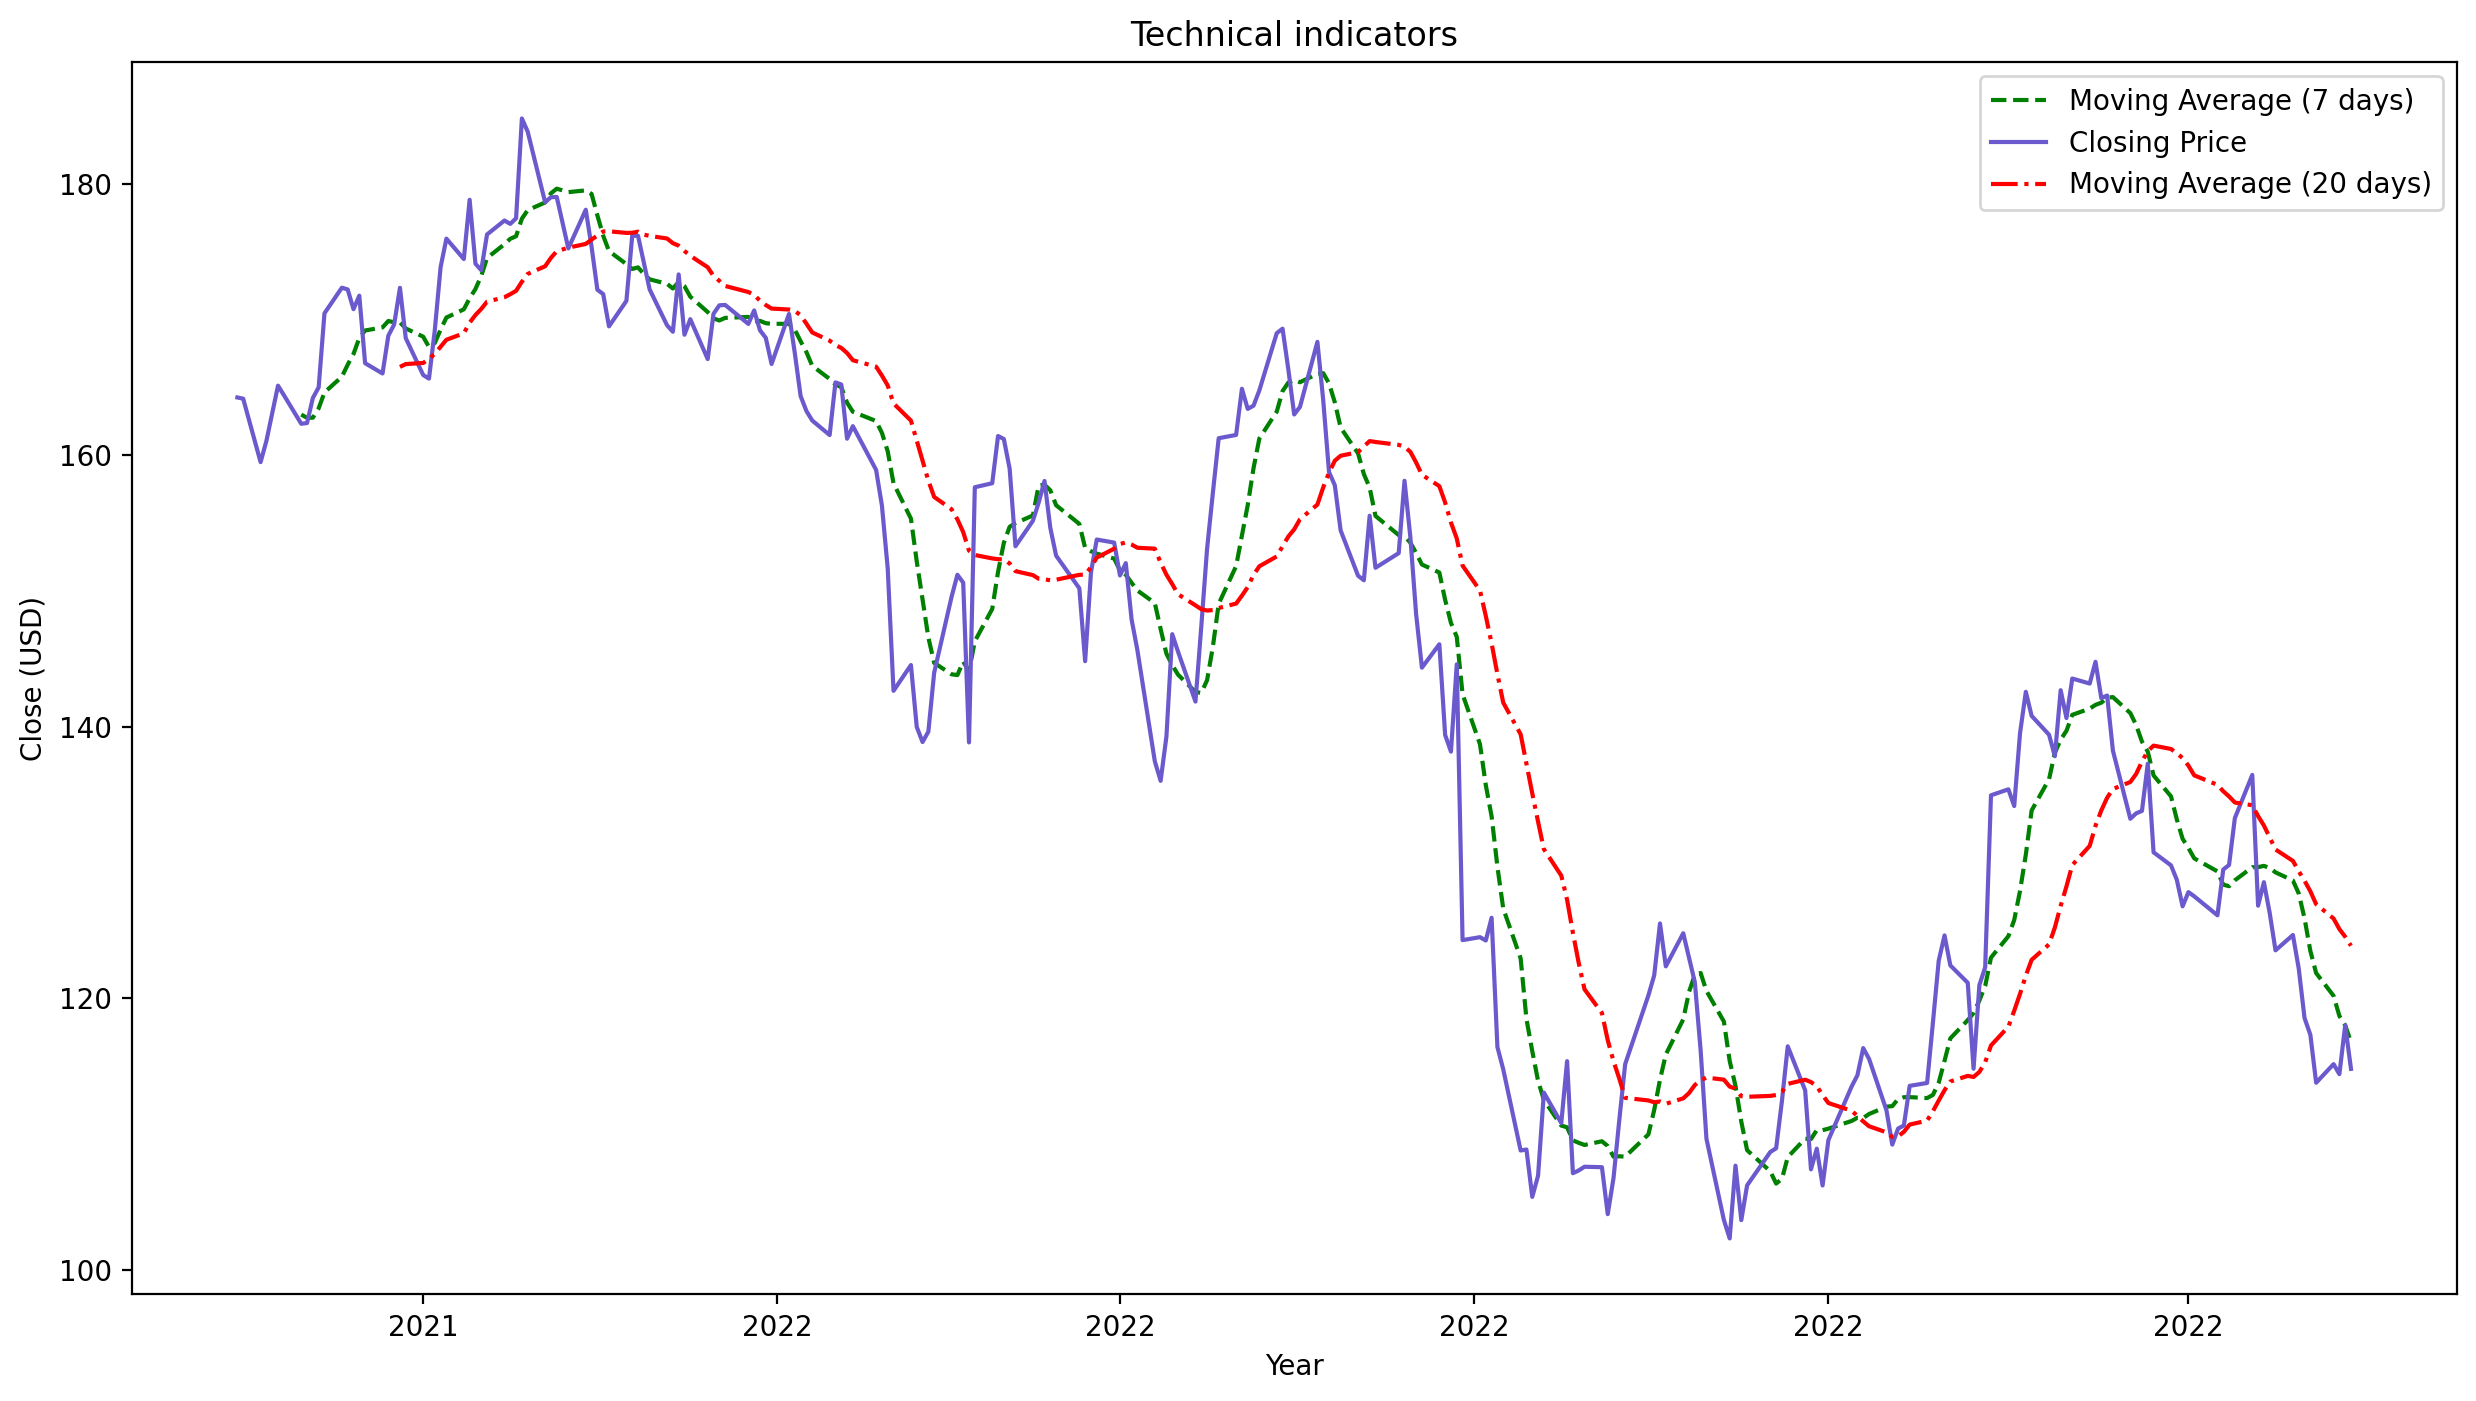

In [237]:
tech_ind(tech_df)

In [238]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [239]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [240]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    
    dump(X_scaler, open('X_scaler(n).pkl', 'wb'))
    dump(y_scaler, open('y_scaler(n).pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [241]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [242]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [243]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [244]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 15)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [245]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

In [246]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True, 
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

In [247]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [248]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 15)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [249]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [250]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences= True, input_shape = (input_dim, feature_size),recurrent_dropout=0.3),
                                 LSTM(units = 512, return_sequences= True,recurrent_dropout=0.3),
                                 LSTM(units = 256, return_sequences= True,recurrent_dropout=0.3),
                                 LSTM(units = 128, return_sequences= True,recurrent_dropout=0.3),
                                 LSTM(units = 64,recurrent_dropout=0.3),
                                 Dense(32),
                                 Dense(16),
                                 Dense(8),
                                 Dense(units=output_dim)])
    
    return model

In [251]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8,input_shape=(input_dim+1, 1), kernel_size = 3, strides = 2, padding = 'same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size = 3, strides = 2, padding = 'same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size = 3, strides = 2, padding = 'same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size = 3, strides = 2, padding = 'same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size = 1, strides = 2, padding = 'same', activation=LeakyReLU(alpha=0.01)))

    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))

    return cnn_net

In [252]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [253]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [254]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/news/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/news/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())
    
        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)
  
    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [255]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/Codes/Python/ML Mini Project/X_scaler(n).pkl', 'rb'))
    y_scaler = load(open('/Codes/Python/ML Mini Project/y_scaler(n).pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

In [256]:
@tf.function 

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [257]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('/Codes/Python/ML Mini Project/X_scaler(n).pkl', 'rb'))
    y_scaler = load(open('/Codes/Python/ML Mini Project/y_scaler(n).pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)
    
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name} using news headlines", fontsize=20)
    plt.show()

In [258]:
learning_rate = 5e-4
epochs = 500

g_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

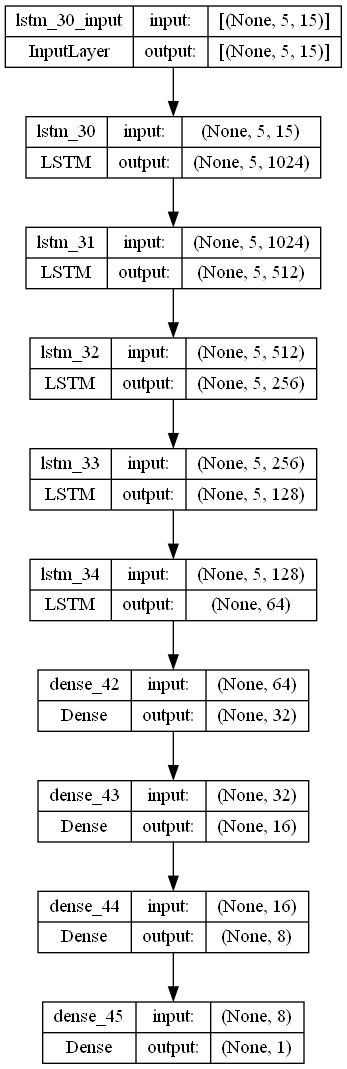

In [259]:
plot_model(generator, to_file='generator_keras_model(n).png', show_shapes=True)

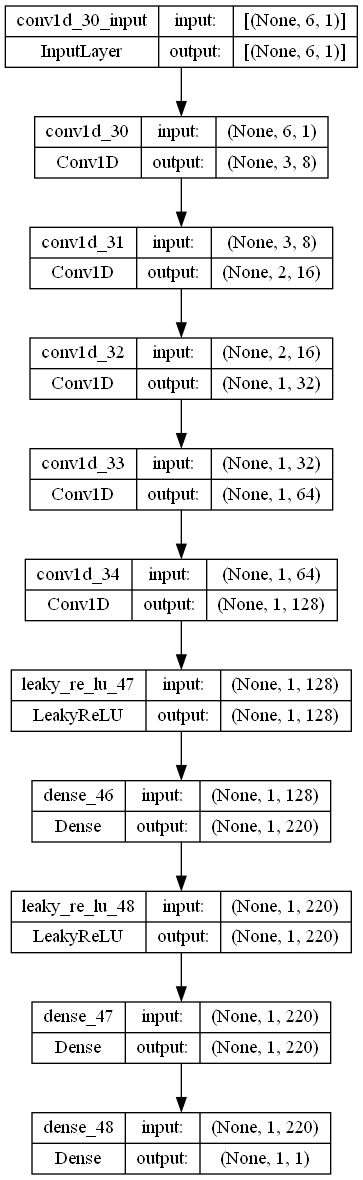

In [260]:

tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model(n).png', show_shapes=True)

 10%|▉         | 49/500 [01:12<07:08,  1.05it/s] 

 10%|█         | 50/500 [01:13<07:23,  1.01it/s]

epoch 50 discriminator_loss 1.3241131 generator_loss 0.7379739


 20%|█▉        | 99/500 [01:59<06:16,  1.06it/s]

 20%|██        | 100/500 [02:00<06:26,  1.03it/s]

epoch 100 discriminator_loss 1.4061422 generator_loss 0.6777564


 30%|██▉       | 149/500 [02:48<05:32,  1.06it/s]

 30%|███       | 150/500 [02:49<05:44,  1.02it/s]

epoch 150 discriminator_loss 1.3880347 generator_loss 0.69200236


 40%|███▉      | 199/500 [03:35<04:43,  1.06it/s]

 40%|████      | 200/500 [03:36<04:52,  1.03it/s]

epoch 200 discriminator_loss 1.3864921 generator_loss 0.6925327


 50%|████▉     | 249/500 [04:23<04:03,  1.03it/s]

 50%|█████     | 250/500 [04:24<04:06,  1.01it/s]

epoch 250 discriminator_loss 1.3869181 generator_loss 0.69269896


 60%|█████▉    | 299/500 [05:11<03:11,  1.05it/s]

 60%|██████    | 300/500 [05:12<03:13,  1.04it/s]

epoch 300 discriminator_loss 1.3873103 generator_loss 0.6873826


 70%|██████▉   | 349/500 [05:59<02:24,  1.04it/s]

 70%|███████   | 350/500 [06:00<02:27,  1.02it/s]

epoch 350 discriminator_loss 1.3882437 generator_loss 0.6916962


 80%|███████▉  | 399/500 [06:47<01:35,  1.05it/s]

 80%|████████  | 400/500 [06:48<01:39,  1.01it/s]

epoch 400 discriminator_loss 1.386573 generator_loss 0.6917504


 90%|████████▉ | 449/500 [07:35<00:50,  1.02it/s]

 90%|█████████ | 450/500 [07:36<00:49,  1.00it/s]

epoch 450 discriminator_loss 1.3863728 generator_loss 0.69891703


100%|█████████▉| 499/500 [08:23<00:00,  1.05it/s]

100%|██████████| 500/500 [08:24<00:00,  1.01s/it]

epoch 500 discriminator_loss 1.3856294 generator_loss 0.6990158


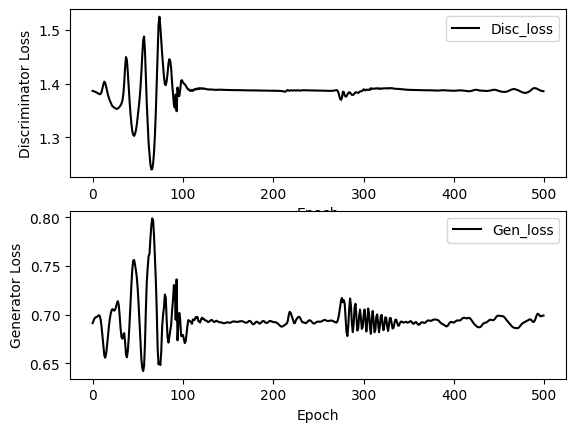

In [261]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [262]:
test_generator = tf.keras.models.load_model(f'./models_gan/news/generator_V_499.h5', compile=False)

Test RMSE:  3.7114005538404156


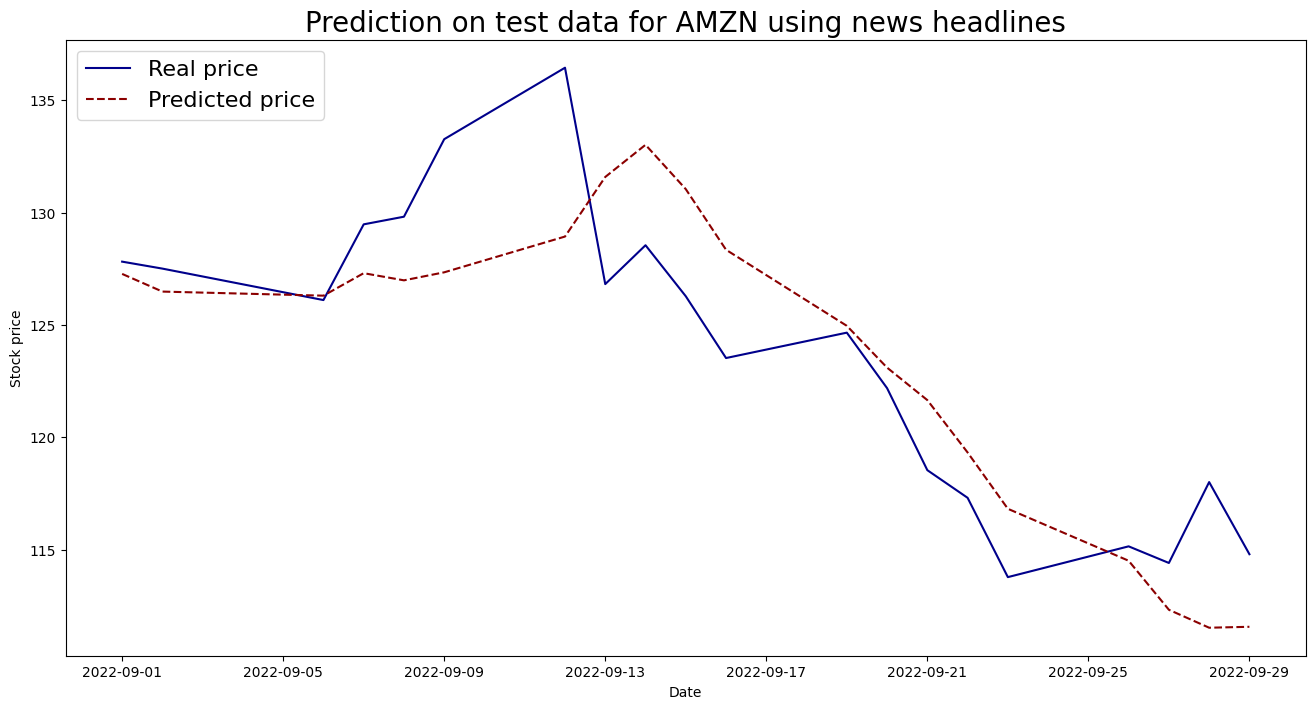

In [263]:
predicted_test_data = eval_op(test_generator, X_test)
type(predicted_test_data)
plot_test_data(y_test, predicted_test_data,index_test)